<a href="https://colab.research.google.com/github/francji1/01RAD/blob/main/code/01RAD_Ex05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01RAD Exercise 05

In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy import stats
from scipy.stats import pearsonr, spearmanr

import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
# Get df
data = sns.load_dataset('mpg').dropna()  # Load and clean dataset
 # Ensure correct data type
data['mpg'] = data['mpg'].astype(float)
data['horsepower'] = data['horsepower'].astype(float)
#data['intercept'] = 1  # Add intercept column if needed (we use smf instead of sm)

In [ ]:
data.dtypes

In [ ]:
data.head()

In [ ]:
data[['displacement','horsepower','weight','acceleration']].corr()

In [ ]:
# Fit model
model = smf.ols('mpg ~ horsepower',data = data).fit()
print(model.summary())


# Relationship between $\hat{\beta}$ and $s_n^2$

In linear regression, we often estimate two key quantities:
- $\hat{\beta}$: the vector of estimated coefficients.
- $s_n^2$: the estimator of the error variance, $\sigma^2$.

## Theoretical Relationship

Under the assumptions of the classical linear regression model, $\hat{\beta}$ and $s_n^2$ are **independent** estimators.

## Tasks:

* How to prove this independence easily with hat matrix?
* How to show this relation with real dataset?


In [ ]:
# Define predictors and response
X = data[['horsepower','weight']].copy()
X['intercept'] = 1
y = data['mpg']

# Number of bootstrap samples
n_bootstraps = 100
beta_estimates = []
sigma_squared_estimates = []

# Perform bootstrap resampling
for _ in range(n_bootstraps):
    # Resample data
    X_resampled, y_resampled = resample(X, y)

    # Fit model on resampled data
    model = sm.OLS(y_resampled, X_resampled).fit()

    # Store bootstrap estimates
    beta_estimates.append(model.params)
    sigma_squared_estimates.append(model.mse_resid)

# Convert to arrays for easy manipulation
beta_estimates = np.array(beta_estimates)
sigma_squared_estimates = np.array(sigma_squared_estimates)

# Calculate correlation between each beta coefficient and s_n^2
for i, beta_name in enumerate(X.columns):
    correlation = np.corrcoef(beta_estimates[:, i], sigma_squared_estimates)[0, 1]
    print(f"Correlation between {beta_name} and s_n^2: {correlation}")


In [ ]:
# Convert to DataFrame for correlation analysis
beta_df = pd.DataFrame(beta_estimates, columns=X.columns)
beta_df['s_n^2'] = sigma_squared_estimates  # Add s_n^2 column

# Calculate the correlation matrix
correlation_matrix = beta_df.corr()
print("Correlation Matrix between each beta estimate and s_n^2:")
print(correlation_matrix)

In [ ]:
observed_correlation = np.corrcoef(sigma_squared_estimates, beta_estimates[:, 0])[0, 1]
num_permutations = 100

boot_correlations = []
for _ in range(num_permutations):
    s_n2_sample, intercept_sample = resample(sigma_squared_estimates, beta_estimates[:, 0])
    boot_correlations.append(np.corrcoef(s_n2_sample, intercept_sample)[0, 1])

# Calculate 95% confidence interval
ci_lower = np.percentile(boot_correlations, 2.5)
ci_upper = np.percentile(boot_correlations, 97.5)
print(f"95% CI for correlation: ({ci_lower}, {ci_upper})")

In [ ]:
pearson_corr, pearson_pval = pearsonr(sigma_squared_estimates, beta_estimates[:, 1])
spearman_corr, spearman_pval = spearmanr(sigma_squared_estimates, beta_estimates[:, 1])

# Print the results
print("Pearson correlation between beta_1 and s_n^2:", pearson_corr)
print("Pearson p-value:", pearson_pval)
print("Spearman correlation between beta_1 and s_n^2:", spearman_corr)
print("Spearman p-value:", spearman_pval)



## Simulation Exercise

To empirically demonstrate the independence of $\hat{\beta}$ and $s_n^2$, we can use simulation.

### Task

1. **Generate Data**: Simulate data based on a simple linear regression model.
   - Set up a design matrix $X$ with an intercept and one or more predictors.
   - Generate response values $Y$ based on a known linear relationship with added Gaussian noise.
   
2. **Estimate $\hat{\beta}$ and $s_n^2$**:
   - Use OLS to compute $\hat{\beta}$ and $s_n^2$ for each simulated dataset.

3. **Repeat Simulations**:
   - Perform the simulation multiple times (e.g., 1000 times) to generate distributions for $\hat{\beta}$ and $s_n^2$.

4. **Calculate Correlation**:
   - Calculate the correlation between the simulated values of $\hat{\beta}$ and $s_n^2$.
   - If $\hat{\beta}$ and $s_n^2$ are independent, the correlation should be close to zero.



In [ ]:
# Set a random seed for reproducibility
np.random.seed(42)

# Generate Synthetic Data with Multicollinearity
n_samples = 60
X1 = np.random.normal(2, 1, n_samples)            # First predictor
X2 = np.random.normal(0, 3, n_samples)# + X1    # Second predictor (highly correlated with X1)
X3 = np.random.normal(4, 1, n_samples)            # Third predictor, independent of X1 and X2
intercept = np.ones(n_samples)                    # Intercept term
y = 3 + 2 * X1 - 1 * X2 + 5 * X3 + np.random.normal(0, 1, n_samples)  # Response variable with noise

# Create DataFrame for regression
df = pd.DataFrame({'intercept': intercept, 'X1': X1, 'X2': X2, 'X3': X3, 'y': y})

# Fit OLS Model
X = df[['intercept', 'X1', 'X2', 'X3']]
y = df['y']
model = sm.OLS(y, X).fit()

# Bootstrap to Test Independence between Intercept and Error Variance Estimator
n_bootstraps = 1000
beta_estimates = []
sigma_squared_estimates = []

for _ in range(n_bootstraps):
    # Resample data with replacement
    X_resampled, y_resampled = resample(X, y)
    # Fit OLS model on resampled data
    model_resampled = sm.OLS(y_resampled, X_resampled).fit()

    # Store the intercept and error variance estimator
    beta_estimates.append(model_resampled.params)
    sigma_squared_estimates.append(model_resampled.mse_resid)

# Convert to DataFrame for easy manipulation
beta_df = pd.DataFrame(beta_estimates, columns=X.columns)
beta_df['s_n^2'] = sigma_squared_estimates

# Calculate Pearson and Spearman Correlations between Intercept and s_n^2
pearson_corr, pearson_pval = pearsonr(beta_df['intercept'], beta_df['s_n^2'])
spearman_corr, spearman_pval = spearmanr(beta_df['intercept'], beta_df['s_n^2'])

# Print the results
print("Pearson correlation between intercept and s_n^2:", pearson_corr)
print("Pearson p-value:", pearson_pval)
print("Spearman correlation between intercept and s_n^2:", spearman_corr)
print("Spearman p-value:", spearman_pval)


In [ ]:
# Calculate the correlation matrix
correlation_matrix = beta_df.corr()
print("Correlation Matrix between each beta estimate and s_n^2:")
print(correlation_matrix)

In [ ]:
x = np.linspace(-10, 10, 100)
x = [1,4,7,3,8,2,20]
y = [1,8,9,4,12,3,13]

In [ ]:
# Plot x vs y
plt.plot(x, y, 'o')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

# Calculate Pearson and Spearman correlation coefficients
pearson_corr, pearson_pval = pearsonr(x, y)
spearman_corr, spearman_pval = spearmanr(x, y)

pearson_corr, pearson_pval, spearman_corr, spearman_pval


In [ ]:
data

In [ ]:
# Generate 3 independent variables that are unrelated to 'mpg'
np.random.seed(42)  # Seed for reproducibility
data['random1'] = np.random.normal(0, 1, len(data))
data['random2'] = np.random.normal(0, 1, len(data))
data['random3'] = np.random.normal(0, 1, len(data))

# Step 2: Fit a model using only these random predictors
# Formula-based model using random variables as predictors
model_random = smf.ols(formula='mpg ~ random1 + random2 + random3', data=data).fit()

# Print summary of the model
print("Model with unrelated predictors:")
print(model_random.summary())


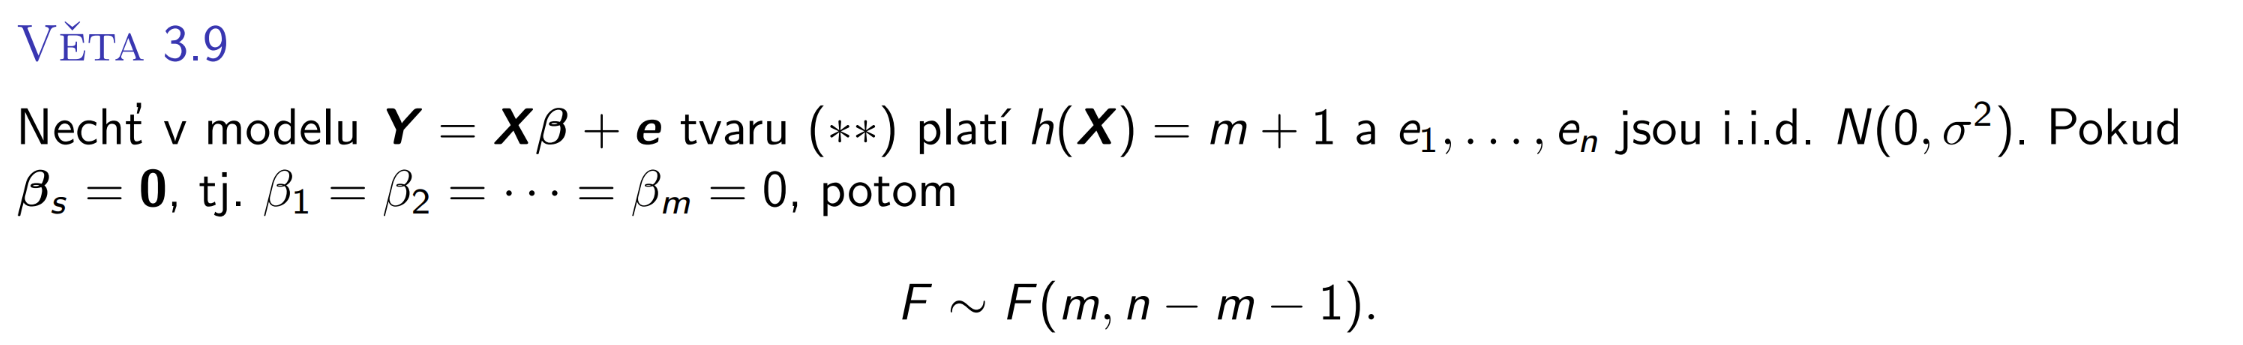

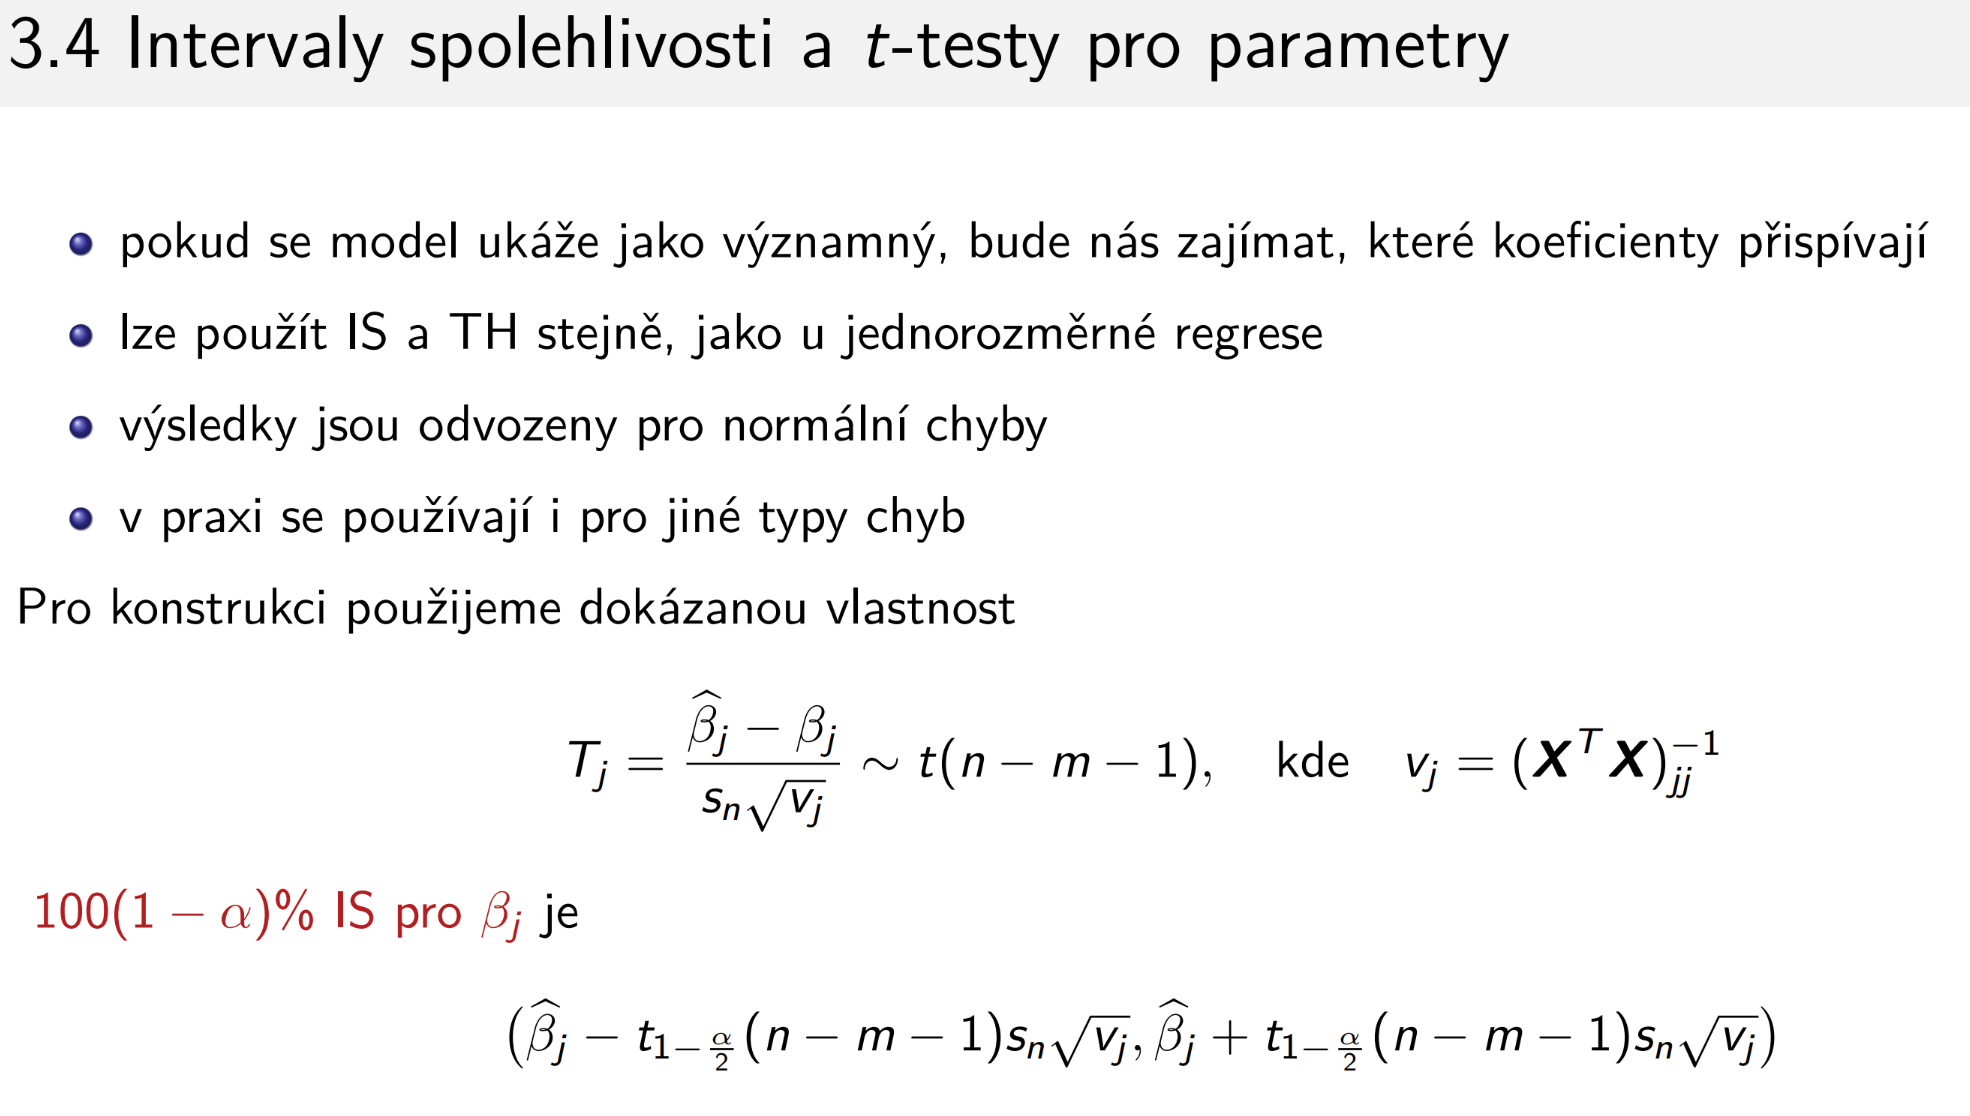

In [ ]:
# Compare the F-test with individual t-tests for each regression coefficient
# F-test p-value (overall model significance)
f_test_pvalue = model_random.f_pvalue

# Individual t-test p-values
t_test_pvalues = model_random.pvalues

print("\nF-test p-value (for the entire model):", f_test_pvalue)
print("Individual t-test p-values (for each coefficient):")
print(t_test_pvalues)

In [ ]:
# Add relevant predictors from the mpg dataset ('horsepower', 'weight', 'displacement' ...)
model_combined = smf.ols(formula='mpg ~ random1 + random2 + random3 + horsepower + weight + acceleration', data=data).fit()

# Print summary of the combined model
print("\nModel with both unrelated and relevant predictors:")
print(model_combined.summary())


In [ ]:
# Compare the F-test with individual t-tests for each regression coefficient
f_test_pvalue_combined = model_combined.f_pvalue
t_test_pvalues_combined = model_combined.pvalues

print("\nF-test p-value (for the combined model):", "{:.4f}".format(f_test_pvalue_combined) )
print("Individual t-test p-values (for each coefficient in the combined model):")
t_test_pvalues_combined_formatted = t_test_pvalues_combined.apply(lambda x: f"{x:.4f}")
print(t_test_pvalues_combined_formatted)


In [ ]:
# Select the final model based on t-test results
final_model_formula = 'mpg ~ horsepower + weight + acceleration'
final_model = smf.ols(formula=final_model_formula, data=data).fit()
print("\nFinal model summary after removing insignificant predictors:")
print(final_model.summary())


In [ ]:
# how to compare pvaules for t test and f test, bonferonni correction etc ...

In [ ]:
# Fit the regression model with the selected predictors
final_model_formula = 'mpg ~ horsepower + weight + displacement'
final_model = smf.ols(formula=final_model_formula, data=data).fit()
print("\nFinal model summary:")
print(final_model.summary())


In [ ]:
# Manually compute standard errors of each coefficient (se_beta_hat)
# Extract X matrix (predictors with intercept) and Y vector
X = final_model.model.exog  # Design matrix including intercept
Y = final_model.model.endog  # Response variable

# Calculate (X^T X)^(-1)
XtX_inv = np.linalg.inv(np.dot(X.T, X))

# Compute s_n (residual standard deviation)
n, p = X.shape  # n = number of observations, p = number of predictors + intercept
RSS = np.sum(final_model.resid**2)
s_n = np.sqrt(RSS / (n - p))

# Compute standard errors using se_beta_hat_i = s_n * sqrt((X^T X)^(-1)_ii)
se_beta_hat_manual = s_n * np.sqrt(np.diag(XtX_inv))
print(np.array([f"{x:.4f}" for x in se_beta_hat_manual]))

In [ ]:
# Manually compute t-tests for each regressor and compare with statsmodels
# Extract the estimated coefficients, standard errors, and degrees of freedom
beta_hat = final_model.params
se_beta_hat = final_model.bse
degrees_of_freedom = final_model.df_resid
print(se_beta_hat)


In [ ]:
# Manually compute t-statistics and p-values for each regressor
t_values_manual = beta_hat / se_beta_hat
p_values_manual = [2 * (1 - stats.t.cdf(np.abs(t), df=degrees_of_freedom)) for t in t_values_manual]

# Print manual t-test results
print("\nManual t-test results:")
for i, predictor in enumerate(final_model.params.index):
    print(f"{predictor}: t-value = {t_values_manual[i]:.4f}, p-value = {p_values_manual[i]:.4g}")


In [ ]:
# Compare with statsmodels' computed t-values and p-values
print("\nStatsmodels t-test results:")
print(final_model.summary2().tables[1][['Coef.', 't', 'P>|t|']])


In [ ]:
# Calculate the overall F-statistic and compare with individual t-tests
f_statistic = final_model.fvalue
f_p_value = final_model.f_pvalue
print(f"\nOverall F-statistic: {f_statistic:.4f}, p-value: {f_p_value:.4g}")

print("\nInterpretation:")



What is the interpretation?

In [ ]:

# Add a highly correlated variable (horsepower with added noise)
data['horsepower_noise'] = data['horsepower'] + np.random.normal(0, 0.01, len(data))
data['weight_noise'] = data['weight'] + np.random.normal(0, 0.01, len(data))


# Refit the model with the added highly correlated variable
model_with_noise = smf.ols(formula='mpg ~ horsepower + weight + displacement + horsepower_noise + weight_noise', data=data).fit()
print("\nModel with highly correlated variables:")
print(model_with_noise.summary())


In [ ]:

# Compute Variance Inflation Factor (VIF) to quantify multicollinearity
X = data[['horsepower', 'weight', 'displacement', 'horsepower_noise' , 'weight_noise']]
X = sm.add_constant(X)  # Add intercept for VIF calculation

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["VIF"] = vif_data["VIF"].apply(lambda x: f"{x:.4f}")

print("\nVariance Inflation Factor (VIF) for each predictor:")
print(vif_data)

# Interpretation
print("\nInterpretation of VIF:")



In [ ]:
# Perform Residual Diagnostics on the Final Model
# Extract residuals and fitted values
residuals = final_model.resid
fitted_values = final_model.fittedvalues
studentized_residuals = final_model.get_influence().resid_studentized_internal

# Histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


In [ ]:

# Plot 2: Q-Q plot of studentized residuals to assess normality
sm.qqplot(studentized_residuals, line='45')
plt.title("Q-Q Plot of Studentized Residuals")
plt.show()


In [ ]:
# Studentized residuals vs. fitted values to check for heteroscedasticity
plt.figure(figsize=(8, 5))
plt.scatter(fitted_values, studentized_residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Studentized Residuals")
plt.title("Studentized Residuals vs. Fitted Values")
plt.axhline(0, color='red', linestyle='--')
plt.show()


In [ ]:
# Residuals vs. Fitted Values plot
# This plot can be generated directly by statsmodels `plot_regress_exog` with 'fittedvalues' parameter
fig, ax = plt.subplots(figsize=(8, 5))
sns.residplot(x=final_model.fittedvalues, y=final_model.resid, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()


In [ ]:
# Studentized residuals vs. each predictor to check for heteroscedasticity or non-linearity
# This checks for residual patterns with each independent variable in the final model
predictors_final_model = final_model_formula.split("~")[1].split("+")  # Extract predictor names from formula

for predictor in predictors_final_model:
    predictor = predictor.strip()
    plt.figure(figsize=(8, 5))
    plt.scatter(data[predictor], studentized_residuals)
    plt.xlabel(predictor)
    plt.ylabel("Studentized Residuals")
    plt.title(f"Studentized Residuals vs. {predictor}")
    plt.axhline(0, color='red', linestyle='--')
    plt.show()


In [ ]:
# Use `plot_regress_exog` for each predictor (covered later)
for predictor in final_model_formula.split("~")[1].split("+"):
    predictor = predictor.strip()
    sm.graphics.plot_regress_exog(final_model, predictor)
    plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
## Load and prepare the dataset
#data = sns.load_dataset('mpg').dropna()
#
## Retain only relevant columns from the mpg dataset and add random predictors
#data = data[['mpg', 'horsepower', 'weight', 'acceleration']]
#data['random1'] = np.random.normal(0, 1, len(data))
#data['random2'] = np.random.normal(0, 1, len(data))
#data['random3'] = np.random.normal(0, 1, len(data))
#print(data.head())

In [ ]:
data

In [ ]:
# Manual backward elimination based on p-values from the t-test
def backward_elimination(data, response, alpha=0.05):
    # Start with all predictors except the response
    predictors = list(data.columns.drop(response))
    formula = f"{response} ~ " + " + ".join(predictors)
    model = smf.ols(formula=formula, data=data).fit()

    while True:
        # Get p-values for all predictors (excluding intercept)
        p_values = model.pvalues.drop('Intercept', errors='ignore')
        max_p_value = p_values.max()

        # Stop if all p-values are below alpha
        if max_p_value < alpha:
            break

        # Find the predictor with the highest p-value
        max_p_variable = p_values.idxmax()

        # Print the variable being removed and its p-value
        print(f"Removing '{max_p_variable}' with p-value {max_p_value:.4f} because it is above the alpha threshold of {alpha}")

        # Remove the variable with the highest p-value from the formula
        predictors.remove(max_p_variable)
        formula = f"{response} ~ " + " + ".join(predictors)
        model = smf.ols(formula=formula, data=data).fit()

    return model

# Run backward elimination and print summary
manual_model = backward_elimination(data.copy(), 'mpg')
print("\nManual Backward Elimination Model Summary:")
print(manual_model.summary())


In [ ]:
# Check for multicollinearity by examining the correlation matrix
corr_matrix = data.corr().abs()
print("\nCorrelation matrix:\n", corr_matrix)

# Set a correlation threshold
corr_threshold = 0.9

# Identify highly correlated pairs of predictors and remove one from each pair
high_corr_pairs = np.where(corr_matrix > corr_threshold)
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j]) for i, j in zip(*high_corr_pairs) if i != j and i < j]
print("\nHighly correlated pairs (above threshold of 0.8):", high_corr_pairs)

# Remove one variable from each highly correlated pair
for (var1, var2) in high_corr_pairs:
    if var1 in data.columns:
        data = data.drop(columns=[var1])

# Updated predictors after removing highly correlated variables
print("\nRemaining predictors after removing correlated variables:\n", data.columns)


In [ ]:
# Stepwise selection using mlxtend's SequentialFeatureSelector
y_mtx = data['mpg']
X_mtx = data.drop(columns=['mpg'])


# Instantiate and perform stepwise selection (forward + backward)
sfs = SFS(LinearRegression(),
          k_features='best',
          forward=True,
          floating=True,  # Allows bidirectional stepwise selection
          scoring='r2',
          cv=5)  # 5-fold cross-validation

sfs = sfs.fit(X_mtx, y_mtx)

# Extract the selected features and fit the final model with statsmodels for comparison
selected_features = list(sfs.k_feature_names_)
formula_mlxtend = 'mpg ~ ' + ' + '.join(selected_features)
model_mlxtend = smf.ols(formula=formula_mlxtend, data=data).fit()

print("\nStepwise Regression (mlxtend) Model Summary:")
print(model_mlxtend.summary())


When performing multiple $t-tests$ for individual predictors, each test has its own probability of a Type I error. This cumulative error rate can lead to an increased chance of falsely rejecting a null hypothesis, known as the family-wise error rate (FWER). To address this, we can apply a p-value correction.

Common corrections include: Bonferroni Correction, Holm-Bonferroni Correction, Tukey, ...

In [ ]:
from statsmodels.stats.multitest import multipletests

# Compare F-test and individual p-values with corrections
f_statistic = manual_model.fvalue
f_p_value = manual_model.f_pvalue
print(f"\nOverall F-statistic: {f_statistic:.4f}, p-value: {f_p_value:.4g}")

# Extract individual p-values from t-tests
individual_pvalues = manual_model.pvalues.drop('Intercept', errors='ignore')
print("\nOriginal individual p-values from t-tests:")
print(individual_pvalues)

# Bonferroni correction is very conservative and may mark fewer predictors as significant.
bonferroni_corrected = multipletests(individual_pvalues, alpha=0.05, method='bonferroni')
print("\nBonferroni corrected p-values:")
for var, p_val, corrected_p, reject in zip(individual_pvalues.index, individual_pvalues, bonferroni_corrected[1], bonferroni_corrected[0]):
    print(f"{var}: original p = {p_val:.4g}, Bonferroni corrected p = {corrected_p:.4g}, significant: {reject}")

# Holm-Bonferroni correction is less conservative and more powerful, as it adjusts in a stepwise manner.
holm_corrected = multipletests(individual_pvalues, alpha=0.05, method='holm')
print("\nHolm-Bonferroni corrected p-values:")
for var, p_val, corrected_p, reject in zip(individual_pvalues.index, individual_pvalues, holm_corrected[1], holm_corrected[0]):
    print(f"{var}: original p = {p_val:.4g}, Holm-Bonferroni corrected p = {corrected_p:.4g}, significant: {reject}")

### What is the conclusion?

### Individual Student Work- HW

1. **Data Exploration and Preprocessing**  
   - Load the same `mpg` dataset, keep only relevant variables, and set `weight` as the response variable.  
   - Add a new categorical variable based on the `origin` column (e.g., convert it to a categorical variable with three levels: `USA`, `Europe`, `Japan`).  
   - Examine the relationship (plot everything important) between `weight` and each predictor variable, including the new categorical variable.

2. **Initial Model Fitting**  
   - Fit an OLS model with `weight` as the response variable and `horsepower`, `displacement`, and `acceleration` as predictors.  
   - Include the categorical variable `origin` as an additional predictor in the model.  
   - Examine the summary output, focusing on the coefficients and the p-values for each predictor.

3. **Evaluate Model with Overall F-Test and Individual t-Tests**  
   - Compute the overall F-test to determine if at least one predictor significantly explains the variance in `weight`.  
   - Compare the F-test result with individual t-tests of each predictor.  
   - Interpret the p-values and discuss the differences between F-test and individual t-tests.
   - Compare $R^2$ with adjusted $R^2$ and explain the difference.

4. **Investigate Correlation**
    - Find in the model two variables with highest correlation and remove one of them from the model.
    - Comapare the new lighter model with the previous full model.
    - Fix common independent variables on the same values (try 3 different setting), choose the value of the removed randomly and comapre the prediction intervals of both models.   

5. **Impact of Categorical Variable on Model**  
    - Fit a model with interaction terms between `origin` and `horsepower` or `displacement` to explore if the effect of these predictors differs by region.  
    - Interpret the interaction terms and examine how the inclusion of the categorical variable changes the model fit and interpretation.

6. **Model Selection with Stepwise Regression**  
   - Implement stepwise regression (either backward or forward) based on p-values to select a subset of predictors.  
   - Compare the final model with the initial model in terms of adjusted \( R^2 \) and AIC values.  

7. **Diagnostic Plots for Residual Analysis**  
   - Create diagnostic plots to assess model assumptions:  
      - Residuals vs. fitted values plot  
      - Q-Q plot for normality of residuals  
      - Histogram of residuals  


